In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.constants import c
from scipy.optimize import curve_fit
from datetime import datetime

#%matplotlib qt

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
#f_carrier = 8431.0165302617e6 before GPSDO software change, average of Oct 11-17th.
f_carrier = 8431.01653051e6

In [3]:
data = np.fromfile('31.dat', sep = ' ').reshape((-1,4))
t_data = Time(data[:,0], format = 'mjd')
freq_data = data[:,1]

In [4]:
gmd_file = '/home/scott/code/GMAT/R2020a/output/ve7til.gmd'
gmd_mjd = []
gmd_rangerate = []
with open(gmd_file) as f:
    for l in f.readlines()[2:]:
        gmd_mjd.append(float(l.split()[0]))
        gmd_rangerate.append(float(l.split()[-1]))
gmd_mjd = np.array(gmd_mjd)
gmd_rangerate = np.array(gmd_rangerate)
t_gmd = Time(gmd_mjd + (2430000.0 - 2400000.5), scale = 'tai', format = 'mjd')

In [5]:
rangerate_interp = np.interp(t_data.utc.mjd, t_gmd.utc.mjd, gmd_rangerate)
freq_gmat = f_carrier * (1 - 1e3*rangerate_interp/c)

rr = -c * ((freq_gmat[1]/f_carrier) - 1) 
print (rr)

rr_p = -c * (((freq_gmat[1]+12.29)/f_carrier) - 1) 
print (rr_p)

print (rr_p - rr)

10609.017390005998
10608.580378757406
-0.4370112485921709


In [6]:
freq_diff = freq_data - freq_gmat
print(sum(freq_diff))

print(len(freq_diff))

sum(freq_diff) / len(freq_diff)

255680.662399292
20272


12.612503078102407

-7.92985267047396e-07 12.620792785282632
15915545.104986545


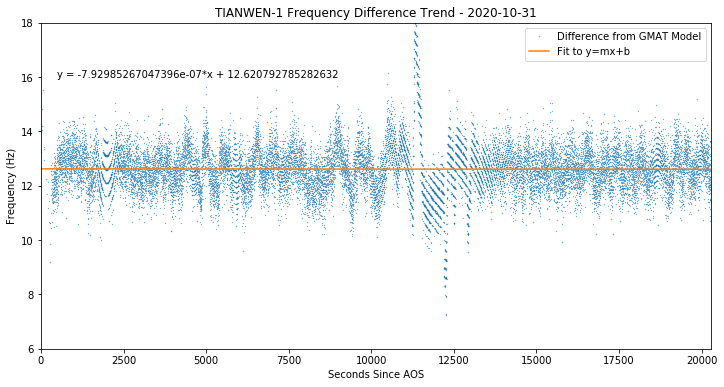

In [10]:
np_diff = np.array(freq_diff)

x = 0
count = t_data.shape[0]
t_zero = (data[0,0] - int(data[0,0])) * 86400
np_t = [0.0] * count

for x in range (0,count):
    np_t[x] = ((data[x,0] - int(data[0,0])) * 86400) - t_zero

    np_t = np.array(np_t)

m, b = np.polyfit(np_t, np_diff,1)
print (m, b)

x=0
x=(0-b)/m
print (x)

plt.ylim(6,18)
plt.xlim(0,len(freq_diff))
plt.plot(np_t, freq_diff, '.',markersize=.5, label = 'Difference from GMAT Model')
plt.plot(np_t, m*np_t + b, label = 'Fit to y=mx+b')
plt.text(500,16, 'y = %s*x + %s'%(m,b))
plt.title('TIANWEN-1 Frequency Difference Trend - %s'%t_data.datetime[0].strftime('%Y-%m-%d'))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Seconds Since AOS')
plt.legend()
plt.show();


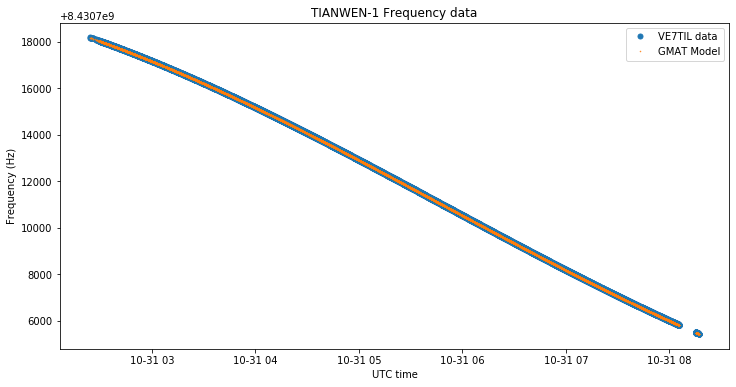

In [8]:
plt.plot(t_data.datetime,freq_data,'.' ,markersize=10, alpha=2, label = 'VE7TIL data')
plt.plot(t_data.datetime, freq_gmat, '.',markersize=1,alpha=1,label = 'GMAT Model')
plt.title('TIANWEN-1 Frequency data')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend()
plt.show();

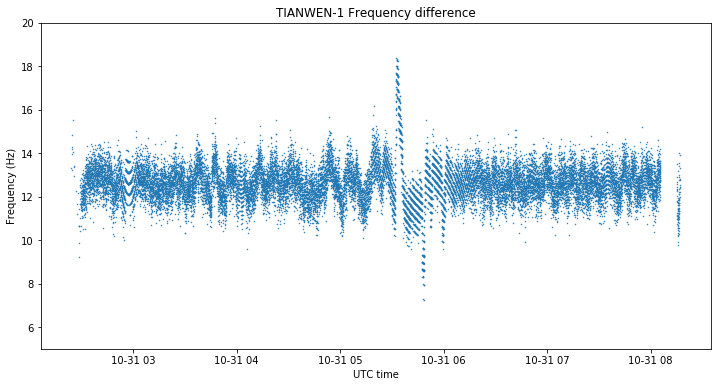

In [9]:
plt.ylim(5,20)
plt.plot(t_data.datetime, freq_data - freq_gmat,'.', markersize=1, label = 'strf file')
plt.title('TIANWEN-1 Frequency difference')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.show()